# Tri-class inifinite radial reservoir classification

## With analytical training data (no wellbore storage) and numerical test data

In [1]:
import sys
print(sys.version)

3.7.4 (default, Apr 17 2020, 16:37:54) 
[GCC 9.2.1 20191008]


In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

FIG_FOLDER="figs/no_storage"
%matplotlib inline

In [ ]:
if not os.path.exists(FIG_FOLDER):
    os.makedirs(FIG_FOLDER, exist_ok=True)

In [3]:
TRAIN_PATH = "../data/analytical/synth_dp.csv"
TEST_PATH = "../data/numerical/Well-2_bhp.csv"
TRAIN_LABELS = "../data/analytical/synth_labels.csv"
TEST_LABELS = "../data/numerical/classes.csv"

In [4]:
train_df = pd.read_csv(TRAIN_PATH, index_col=None, header=0)
train_df.columns = train_df.columns.astype(np.int)

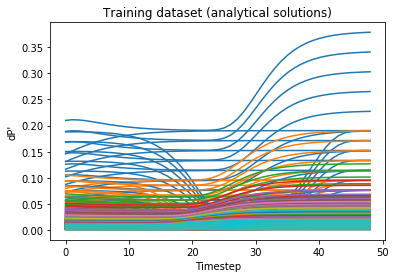

In [5]:
plt.plot(list(range(train_df.shape[0])), train_df.values)
plt.title("Training dataset (analytical solutions)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [6]:
train_labels = pd.read_csv(TRAIN_LABELS, header=0)
train_labels.shape

(600, 2)

In [7]:
train_labels.groupby("class").count()

,scenario_id
class,
FAULT,200
FRACTURE,200
HOMOGENEOUS,200


In [8]:
train_labels.index = train_labels.scenario_id.astype(np.int)
train_labels = train_labels.drop(columns=['scenario_id'])

If we use the scenarios without wellbore storage and skin for training, however, we may use all of the numerical **fracture** scenarios for testing the classification models.

In [9]:
skin_df = pd.read_csv("../data/rodada_14/synth_dp_cd_s.csv", index_col=None, header=0)
skin_df.columns = skin_df.columns.astype(np.int)

In [10]:
skin_labels = pd.read_csv("../data/rodada_14/synth_labels_cd_s.csv", header=0)
skin_labels.index = skin_labels.scenario_id.astype(np.int)
skin_labels = skin_labels.drop(columns=['scenario_id'])

In [11]:
sfracture_idx = skin_labels[skin_labels == "FRACTURE"].dropna().index
sfracture_idx

Int64Index([201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
            ...
            391, 392, 393, 394, 395, 396, 397, 398, 399, 400],
           dtype='int64', name='scenario_id', length=200)

In [12]:
skin_df_frac = skin_df[sfracture_idx]
skin_df_frac.shape

(49, 200)

In [13]:
skin_labels = skin_labels.loc[sfracture_idx]

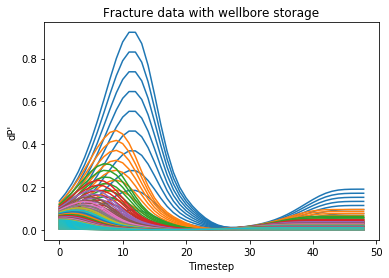

In [14]:
plt.plot(list(range(skin_df_frac.shape[0])), skin_df_frac.values)
plt.title("Fracture data with wellbore storage")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

Now, the skin **fracture** data will be added to the test dataset in its integrity. This may lead to an imbalance that will be corrected once we load the test data.

## Plotting the dataset colored by class

In [15]:
CLASS_COLORS = {
    "FAULT": "r",
    "FRACTURE": "g",
    "HOMOGENEOUS": "b",
}

In [16]:
def plot_by_class(data, labels, data_name=""):
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(7, 14))

    for s in data:
        color = CLASS_COLORS[labels['class'][s]]
        ax = ax3
        if color == 'r':
            ax = ax1
        elif color == 'g':
            ax = ax2

        ax.plot(list(range(data.shape[0])), data[s], c=color)

    ax2.set_ylabel("dP'")
    ax3.set_xlabel("Timestep")

    line_legend_elements = [Line2D([0], [0], color=CLASS_COLORS['FAULT'], label='FAULT'),
                            Line2D([0], [0], color=CLASS_COLORS['FRACTURE'], label='FRACTURE'),
                            Line2D([0], [0], color=CLASS_COLORS['HOMOGENEOUS'], label='HOMOGENEOUS')]

    ax3.legend(handles=line_legend_elements)
    ax1.set_title(f'Pressure derivative - {data_name}\nClass = FAULT')
    ax2.set_title('Class = FRACTURE')
    ax3.set_title('Class = HOMOGENEOUS')
    return fig, [ax1, ax2, ax3]

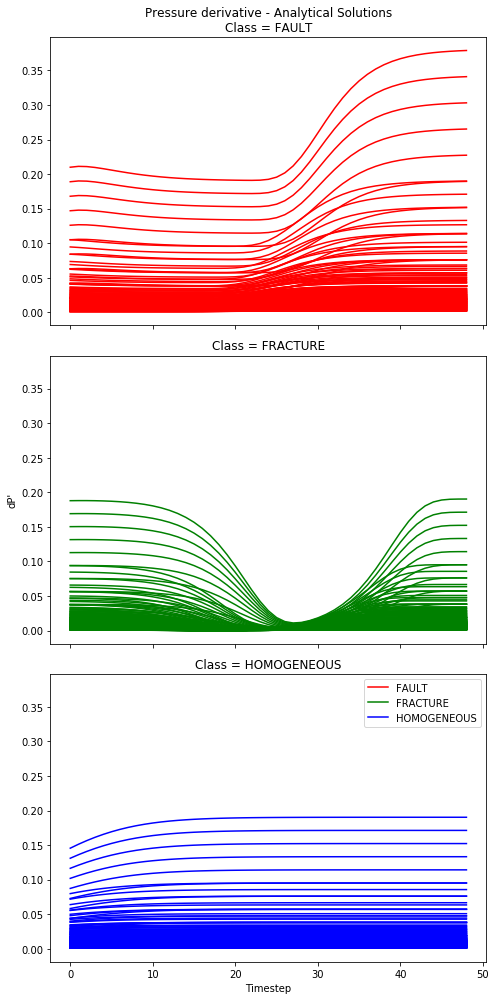

In [17]:
plot_by_class(train_df, labels=train_labels, data_name="Analytical Solutions")
plt.tight_layout()
plt.savefig(f"{FIG_FOLDER}/training_data_by_class.pdf", bbox_inches="tight")

## Data distribution inspection

In [18]:
from sklearn.manifold import MDS

In [19]:
def plot_mds(data, labels, title=""):
    if not title:
        title = "MDS projection of the data"

    coords = MDS(n_components=2).fit_transform(data)
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, p in enumerate(coords):
        ax.scatter(p[0], p[1], c=CLASS_COLORS[labels["class"].iloc[i]])

    ax.set_title(title, fontweight="bold")

    scatter_legend_elements = [Line2D([0], [0], marker='o', color='w', label='FAULT',
                                      markerfacecolor=CLASS_COLORS['FAULT'], markersize=8),
                               Line2D([0], [0], marker='o', color='w', label='FRACTURE',
                                      markerfacecolor=CLASS_COLORS['FRACTURE'], markersize=8),
                               Line2D([0], [0], marker='o', color='w', label='HOMOGENEOUS',
                                      markerfacecolor=CLASS_COLORS['HOMOGENEOUS'], markersize=8)]
    ax.legend(handles=scatter_legend_elements)
    return ax

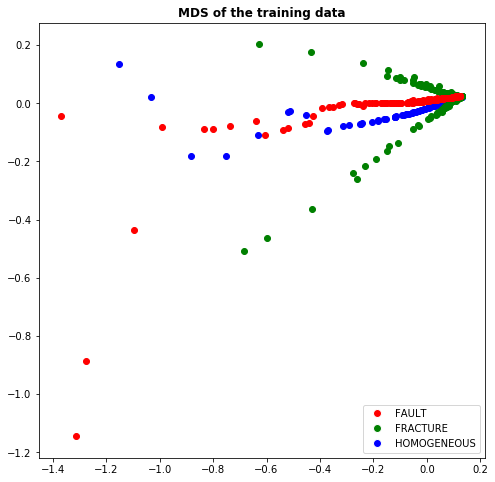

In [20]:
plot_mds(train_df.T, labels=train_labels, title="MDS of the training data")
plt.savefig(f"{FIG_FOLDER}/mds_training_data.pdf", bbox_inches="tight")
plt.show()

## Normalization and Scaling of the training data

### Standard scaling

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
X_scaled = StandardScaler().fit_transform(train_df.values.T)
X_scaled.shape

(600, 49)

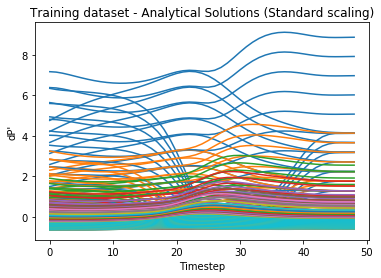

In [23]:
plt.plot(X_scaled.T)
plt.title("Training dataset - Analytical Solutions (Standard scaling)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [24]:
X_scaled_df = pd.DataFrame(data=X_scaled.T, columns=train_df.columns)

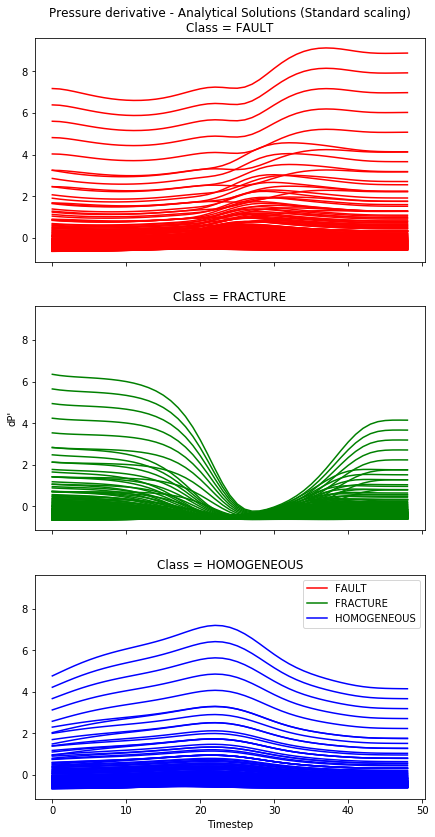

In [25]:
plot_by_class(X_scaled_df, train_labels, data_name="Analytical Solutions (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/std_centering_training_by_class.pdf", bbox_inches="tight")
plt.show()

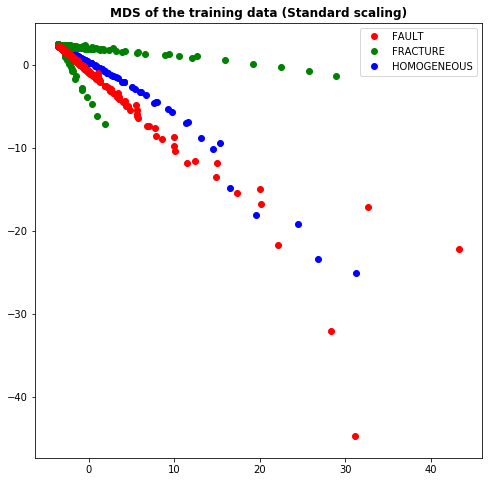

In [26]:
plot_mds(X_scaled, labels=train_labels, title="MDS of the training data (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/mds_std_centering_training.pdf", bbox_inches="tight")
plt.show()

### Normalizing the curves

In [27]:
from sklearn.preprocessing import Normalizer

In [28]:
X_norm = Normalizer().fit_transform(train_df.values.T)
X_norm.shape

(600, 49)

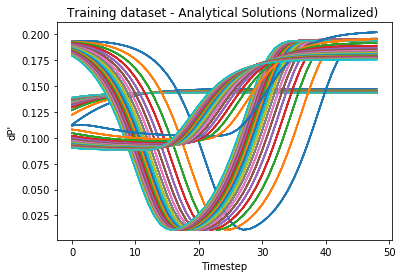

In [29]:
plt.plot(X_norm.T)
plt.title("Training dataset - Analytical Solutions (Normalized) ")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [30]:
X_norm_df = pd.DataFrame(data=X_norm.T, columns=train_df.columns)

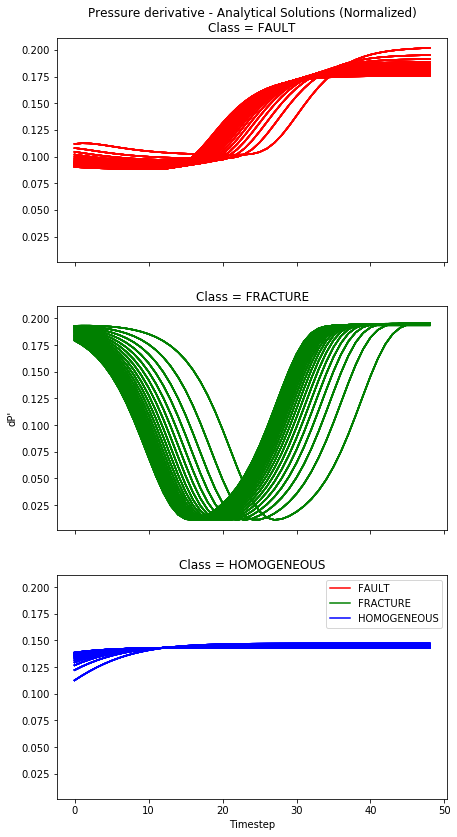

In [31]:
plot_by_class(X_norm_df, train_labels, data_name="Analytical Solutions (Normalized)")
plt.savefig(f"{FIG_FOLDER}/normalized_training_by_class.pdf", bbox_inches="tight")
plt.show()

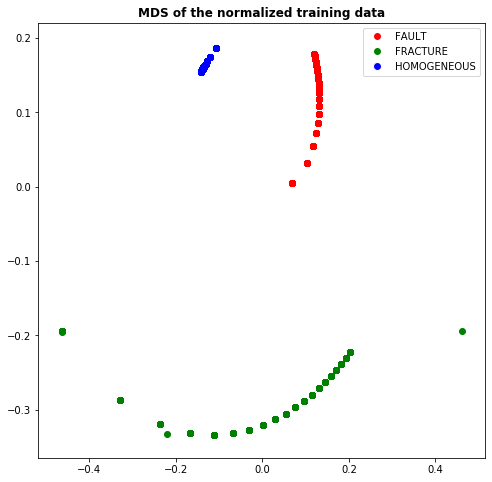

In [32]:
plot_mds(X_norm.astype(np.float16), labels=train_labels, title="MDS of the normalized training data")
plt.show()

## Calculating the shapelets for the training data

Now, we calculate the shapelets for both the scaled and normalized data

In [33]:
from classifier.shapelets import extract_shapelets, subsequence_dist

In [34]:
def calc_shapelets(data, labels, verbose=False):
    """Calculates the shapelets for a given dataset.

    Parameters
    ----------
    data : pandas.DataFrame
    labels : pandas.DataFrame
    """
    data_class = [None] * data.shape[1]
    for i, val in enumerate(data.values.T):
        data_class[i] = (val, labels.values[i])
        print(labels.values[i])

    return extract_shapelets(data_class, min_len=5, max_len=25, verbose=verbose)

Shapelets calculation may take a very long time and, its use may not be as advantageous as indicated. Thus, we select a fraction of the dataset to obtain the shapelets.

In [35]:
PERC_ELEMENTS = 0.1
chosen_idx = {}

for label in train_labels["class"].unique():
    idx = train_labels[train_labels == label].dropna().index
    chosen_idx[label] = np.random.choice(idx, np.int(PERC_ELEMENTS * len(idx)), replace=False)

In [36]:
train_shapelet = []
train_labels_shapelet = []

for label, idx in chosen_idx.items():
    if not len(train_shapelet):
        train_shapelet = X_scaled_df[idx]
        train_labels_shapelet = train_labels.loc[idx]
    else:
        train_shapelet = pd.concat([train_shapelet, X_scaled_df[idx]], axis=1)
        train_labels_shapelet = pd.concat([train_labels_shapelet, train_labels.loc[idx]])

train_shapelet.shape

(49, 60)

In [37]:
if not os.path.exists("shapelet_synth_sample_scaled.pickle"):
    shapelets_train_scaled = calc_shapelets(train_shapelet, train_labels_shapelet)
    fname = "shapelet_synth_sample_scaled.pickle"
    with open(os.path.join(".", fname), "wb") as fout:
        pickle.dump(shapelets_train_scaled, fout)
else:
    with open("shapelet_synth_sample_scaled.pickle", "rb") as fin: 
        shapelets_train_scaled = pickle.load(fin)

['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT' 'FRACTURE' 'HOMOGENEOUS']
Extracting shapelets for FAULT
Extracting shapelets for FRACTURE
Extracting shapelets for HOMOGENEOUS


In [38]:
train_shapelet = []
train_labels_shapelet = []

for label, idx in chosen_idx.items():
    if not len(train_shapelet):
        train_shapelet = X_norm_df[idx]
        train_labels_shapelet = train_labels.loc[idx]
    else:
        train_shapelet = pd.concat([train_shapelet, X_norm_df[idx]], axis=1)
        train_labels_shapelet = pd.concat([train_labels_shapelet, train_labels.loc[idx]])

train_shapelet.shape

(49, 60)

In [39]:
if not os.path.exists("shapelet_synth_sample_norm.pickle"):
    shapelets_train_norm = calc_shapelets(train_shapelet, train_labels_shapelet)
    fname = "shapelet_synth_sample_norm.pickle"
    with open(os.path.join(".", fname), "wb") as fout:
        pickle.dump(shapelets_train_norm, fout)
else:
    with open("shapelet_synth_sample_norm.pickle", "rb") as fin: 
        shapelets_train_norm = pickle.load(fin)

['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['HOMOGENEOUS']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FRACTURE']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT']
['FAULT' 'FRACTURE' 'HOMOGENEOUS']
Extracting shapelets for FAULT
Extracting shapelets for FRACTURE
Extracting shapelets for HOMOGENEOUS


## Training the classification models

In [40]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [41]:
from classifier.voting import GSVotingClassifier

In [42]:
clf_names = ["knn", "decision_tree", "linear_svc", "perceptron", "random_forest","adaboost", "mlperceptron"]
clf_instances = [KNeighborsClassifier(), DecisionTreeClassifier(), LinearSVC(), Perceptron(), RandomForestClassifier(), AdaBoostClassifier(), MLPClassifier()]
clf_params = [
    {
        'n_neighbors': np.arange(4, 31),
    },
    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'random_state': [42],
        'min_samples_leaf': np.arange(2, 31),
    },
    {
        'penalty': ['l1', 'l2'],
        'dual': [True, False],
        'C': np.arange(1, 10),
        'random_state': [42],
        'max_iter': [10000],
        'multi_class': ['ovr', 'crammer_singer'],
    },
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'max_iter': [10000],
        'early_stopping': [True],
    },
    {
        'criterion': ['gini', 'entropy'],
        'random_state': [42],
        'min_samples_leaf': np.arange(2, 31),
        'n_estimators': np.arange(10, 200, 10),
    },
    {
        'random_state': [42],
    },
    {
        'random_state': [42],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'adam'],
        'early_stopping': [True],
        'validation_fraction': [0.2],
        'hidden_layer_sizes': [(100), (100, 100), (100, 100, 100)]
    }
]

In [43]:
clf = {}
clf["scaled"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                   voting_type="hard", cv=10, top_n=5)
clf["scaled_shapelet"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                            voting_type="hard", cv=10, top_n=5)
clf["norm"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                 voting_type="hard", cv=10, top_n=5)
clf["norm_shapelet"] = GSVotingClassifier(estimators=zip(clf_names, clf_instances, clf_params),
                                          voting_type="hard", cv=10, top_n=5)

In [44]:
X = {}
X["scaled"] = X_scaled
X["norm"] = X_norm

In [45]:
def calc_shapelets_dataset(data, shapelets):
    full_dist = []
    for d in data:
        dists = []
        for val in shapelets.values():
            dist, _ = subsequence_dist(list(d), val)
            dists.append(dist)
        full_dist.append(dists)
    return np.array(full_dist)

In [46]:
X["scaled_shapelet"] = calc_shapelets_dataset(X_scaled, shapelets_train_scaled)
X["norm_shapelet"] = calc_shapelets_dataset(X_norm, shapelets_train_norm)

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k, c in clf.items():
        c.fit(X[k], train_labels.values.ravel())

In [48]:
for k, v in clf.items():
    print(k)
    for e in v.estimators_:
        print(e)

scaled
('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'))
('linear_svc', LinearSVC(C=7, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='crammer_singer', penalty='l1', random_state=42,
          tol=0.0001, verbose=0))
('perceptron', Perceptron(alpha=0.0001, class_weight=None, early_stopping=True, eta0=1.0,
           fit_intercept=True, max_iter=10000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False))
('random_forest', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
          

## Loading and inspecting the test data

In [49]:
test_df = pd.read_csv(TEST_PATH, index_col=0, header=0)
test_df.columns = test_df.columns.astype(np.int)
test_df.shape

(51, 384)

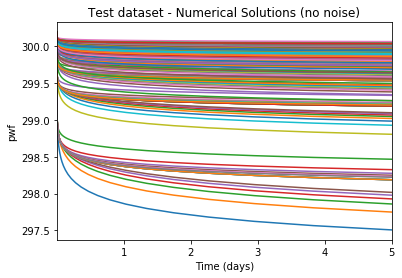

In [50]:
ax = test_df.plot(legend=False)
ax.set_title("Test dataset - Numerical Solutions (no noise)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("pwf")
plt.show()

Reading the test data labels

In [51]:
test_labels = pd.read_csv(TEST_LABELS, header=0)
test_labels.shape

(384, 2)

In [52]:
test_labels.groupby("class").count()

,scenario_id
class,
FAULT,128
FRACTURE,128
HOMOGENEOUS,128


In [53]:
test_labels.index = test_labels.scenario_id.astype(np.int)
test_labels = test_labels.drop(columns=['scenario_id'])

Now, we discard the scenarios with **fracture** class from the test dataset and merge the analytical fracture model scenarios held out fom training into the test data frame

In [54]:
fracture_idx = test_labels[test_labels == "FRACTURE"].dropna().index
fracture_idx

Int64Index([ 13,  14,  15,  16,  17,  18,  35,  36,  37,  38,
            ...
            375, 376, 377, 378, 379, 380, 381, 382, 383, 384],
           dtype='int64', name='scenario_id', length=128)

In [55]:
test_df = test_df.drop(columns=fracture_idx)
test_df.shape

(51, 256)

In [56]:
test_labels = test_labels.drop(index=fracture_idx)
test_labels.shape

(256, 1)

Now, we will sort the data frame and labels by their indices and relabel them. This is because the **fracture** scenarios removed left several "holes" in the test data index. Also, the indices of analytical **fracture** scenarios witheld from training clash with indices of the remaining test scenarios.

In [57]:
test_df.sort_index(inplace=True, axis=1)
test_df.columns = range(1, test_df.shape[1] + 1)
test_labels.sort_index(inplace=True, axis=0)
test_labels.index = range(1, test_df.shape[1] + 1)

Before the merge, we must calculate the pressure derivative.

In [58]:
from sim import calc_log_derivative

In [59]:
test_df = 300 - test_df
test_df = test_df.apply(calc_log_derivative)
test_df.shape

(49, 256)

If we use the data without skin and wellbore storage for the model training, we simply choose a number of fracture scenarios witheld earlier (to keep a balanced dataset) and add them to the tests here.

In [60]:
skin_test_idx = np.random.choice(skin_df_frac.columns, 128, replace=False)
skin_df_frac = skin_df_frac[skin_test_idx]
skin_labels = skin_labels.loc[skin_test_idx]

In [61]:
skin_df_frac.sort_index(inplace=True, axis=1)
skin_df_frac.columns = range(test_df.shape[1] + 1, test_df.shape[1] + skin_df_frac.shape[1] + 1)
skin_labels.sort_index(inplace=True, axis=0)
skin_labels.index = range(test_df.shape[1] + 1, test_df.shape[1] + skin_df_frac.shape[1] + 1)

In [62]:
test_labels = pd.concat([test_labels, skin_labels])

In [63]:
test_df = pd.concat([test_df.reset_index(drop=True), skin_df_frac], axis=1)
test_df.shape

(49, 384)

Text(0, 0.5, "dP'")

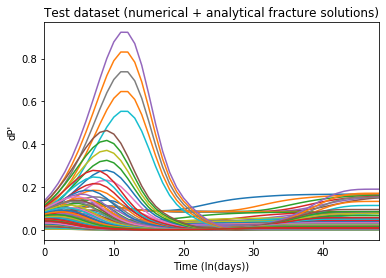

In [64]:
ax = test_df.plot(legend=False)
ax.set_title("Test dataset (numerical + analytical fracture solutions)")
ax.set_xlabel("Time (ln(days))")
ax.set_ylabel("dP'")

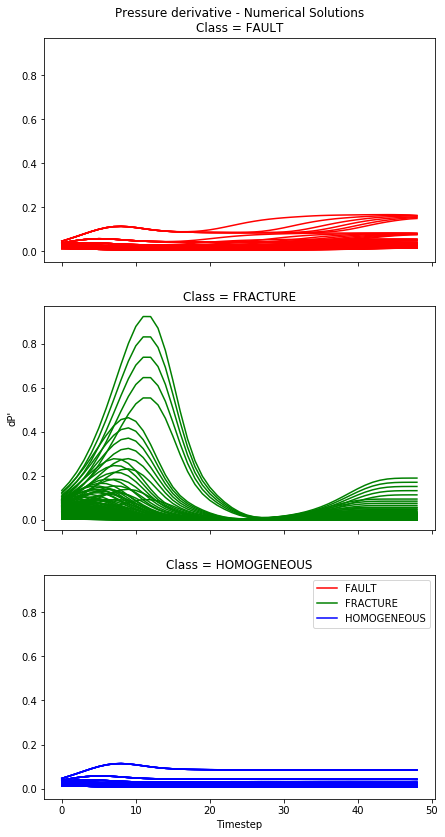

In [65]:
plot_by_class(test_df, test_labels, data_name="Numerical Solutions")
plt.savefig(f"{FIG_FOLDER}/test_data_by_class.pdf", bbox_inches="tight")
plt.show()

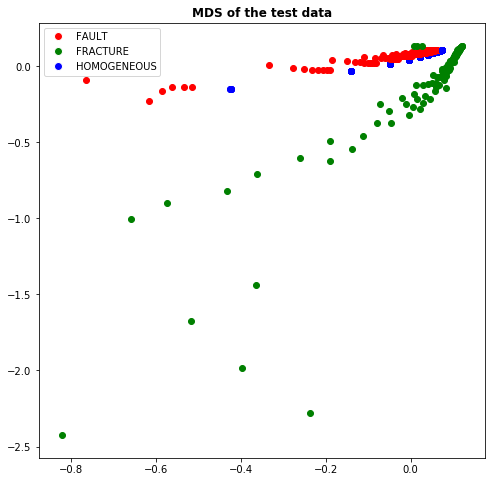

In [66]:
plot_mds(test_df.T, labels=test_labels, title="MDS of the test data")
plt.savefig(f"{FIG_FOLDER}/mds_test_data.pdf", bbox_inches="tight")
plt.show()

### Standard scaling

In [67]:
X_scaled_test = StandardScaler().fit_transform(test_df.values.T)
X_scaled_test.shape

(384, 49)

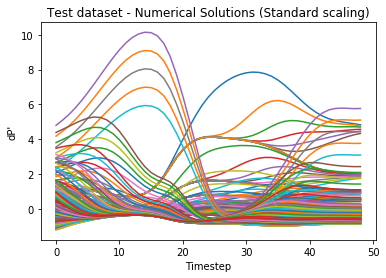

In [68]:
plt.plot(X_scaled_test.T)
plt.title("Test dataset - Numerical Solutions (Standard scaling)")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [69]:
X_scaled_test_df = pd.DataFrame(data=X_scaled_test.T, columns=test_df.columns)

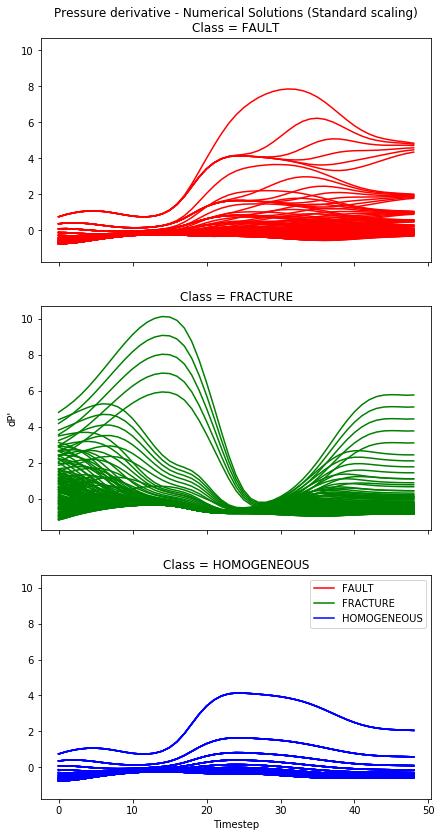

In [70]:
plot_by_class(X_scaled_test_df, test_labels, data_name="Numerical Solutions (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/std_centering_test_by_class.pdf", bbox_inches="tight")
plt.show()

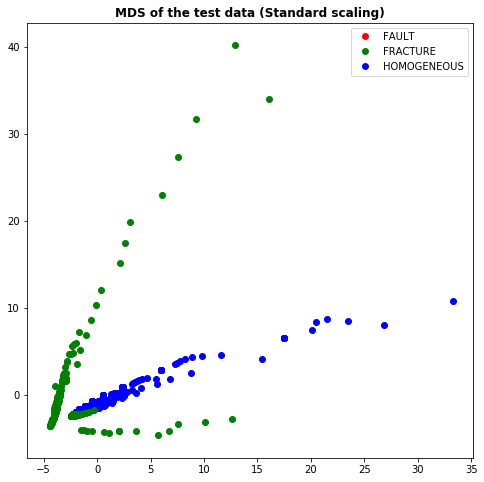

In [71]:
plot_mds(X_scaled_test, labels=train_labels, title="MDS of the test data (Standard scaling)")
plt.savefig(f"{FIG_FOLDER}/mds_std_centering_test.pdf", bbox_inches="tight")
plt.show()

### Normalizing the test data to norm 1

In [72]:
X_norm_test = Normalizer().fit_transform(test_df.values.T)
X_norm_test.shape

(384, 49)

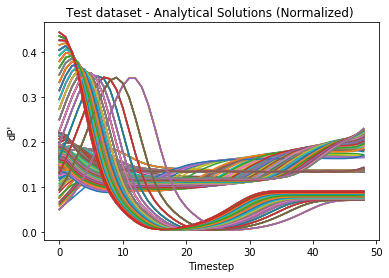

In [73]:
plt.plot(X_norm_test.T)
plt.title("Test dataset - Analytical Solutions (Normalized) ")
plt.xlabel("Timestep")
plt.ylabel("dP'")
plt.show()

In [74]:
X_norm_test_df = pd.DataFrame(data=X_norm_test.T, columns=test_df.columns)

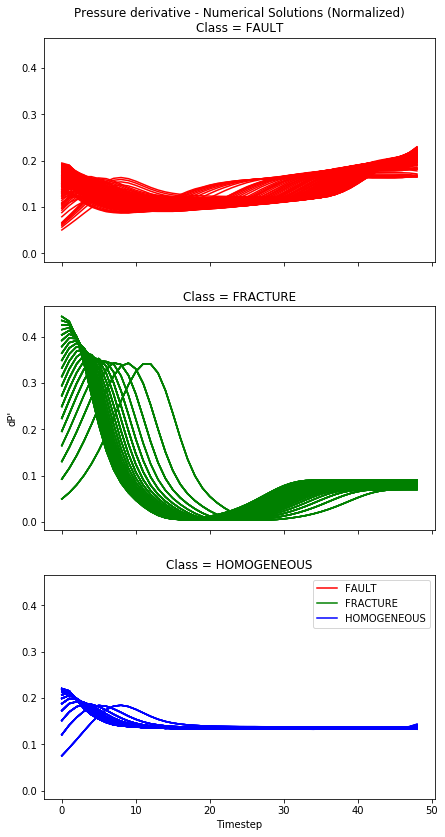

In [75]:
plot_by_class(X_norm_test_df, test_labels, data_name="Numerical Solutions (Normalized)")
plt.savefig(f"{FIG_FOLDER}/normalized_test_by_class.pdf", bbox_inches="tight")
plt.show()

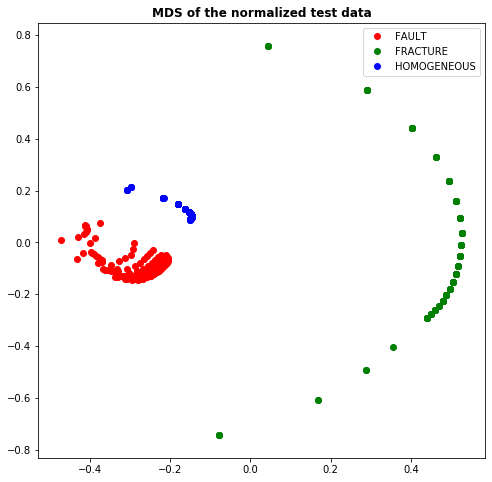

In [76]:
plot_mds(X_norm_test.astype(np.float32), labels=test_labels, title="MDS of the normalized test data")
plt.savefig(f"{FIG_FOLDER}/mds_normalized_test.pdf", bbox_inches="tight")
plt.show()

## Finally the actual prediction and classification metrics calculation

First, we process the shapelets versions of the dataset and insert them in a dict.

In [77]:
X_test = {}
X_test["scaled"] = X_scaled_test
X_test["norm"] = X_norm_test

In [78]:
X_test["scaled_shapelet"] = calc_shapelets_dataset(X_scaled_test, shapelets_train_scaled)
X_test["norm_shapelet"] = calc_shapelets_dataset(X_norm_test, shapelets_train_norm)

Now, we run the prediction itself.

In [79]:
yhat = {}
for k, v in clf.items():
    yhat[k] = v.predict(X_test[k])

Now, we calculate the classification metrics

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [81]:
le = clf["scaled"].le_
ytrue = test_labels.values.ravel()

In [93]:
for k, v in yhat.items():
    print(k.upper())
    print(precision_recall_fscore_support(ytrue, v, labels=le.classes_, beta=1, average="macro"))
    print(classification_report(ytrue, v, labels=le.classes_, digits=3))
    print("---------------------------------------------------------")

SCALED
(0.799582027168234, 0.78125, 0.7820491363265379, None)
              precision    recall  f1-score   support

       FAULT      0.709     0.914     0.799       128
    FRACTURE      1.000     0.805     0.892       128
 HOMOGENEOUS      0.690     0.625     0.656       128

    accuracy                          0.781       384
   macro avg      0.800     0.781     0.782       384
weighted avg      0.800     0.781     0.782       384

---------------------------------------------------------
SCALED_SHAPELET
(0.34560344631612455, 0.3802083333333333, 0.35728395061728396, None)
              precision    recall  f1-score   support

       FAULT      0.483     0.648     0.553       128
    FRACTURE      0.395     0.383     0.389       128
 HOMOGENEOUS      0.159     0.109     0.130       128

    accuracy                          0.380       384
   macro avg      0.346     0.380     0.357       384
weighted avg      0.346     0.380     0.357       384

---------------------------------

Finally, let's plot the mismatched curves by class.

## Plotting the mismatched curves

In [83]:
data_name_prettyname = {
    "scaled": "Scaled",
    "norm": "Normalized",
    "scaled_shapelet": "Scaled (Shapelets)",
    "norm_shapelet": "Normalized (Shapelets)",
}

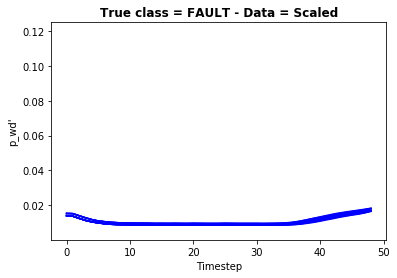

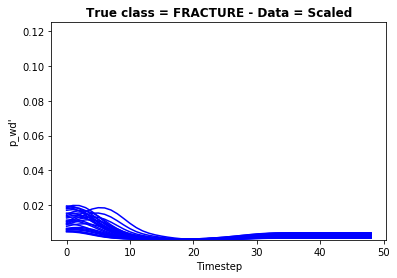

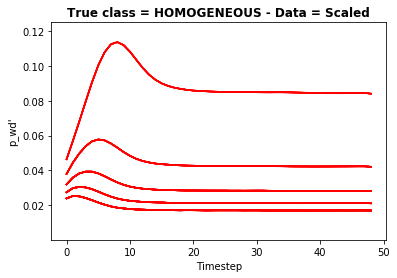

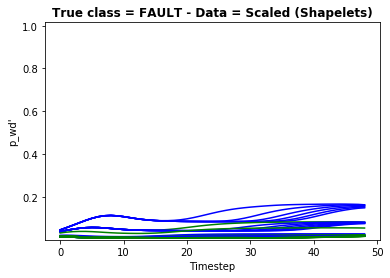

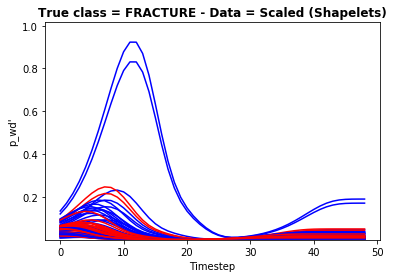

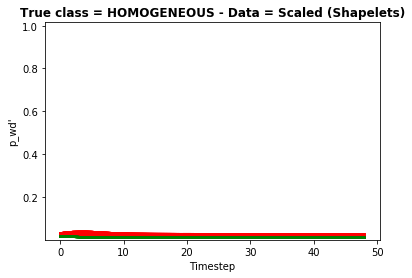

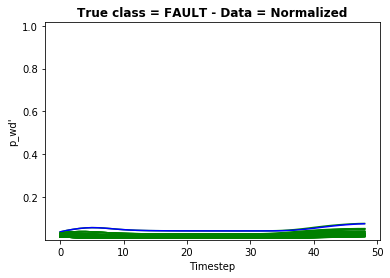

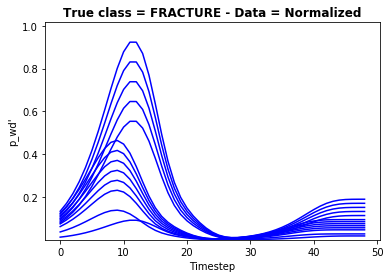

In [84]:
for k in yhat.keys():
    mismatched_idx = np.argwhere(ytrue != yhat[k]).ravel()

    if not any(mismatched_idx):
        continue
    
    ylims = (0.9 * test_df[mismatched_idx + 1].min().min(), 1.1 * test_df[mismatched_idx + 1].max().max())

    for c in le.classes_:
        mismatched_idx_class = ytrue[mismatched_idx] == c
        if not any(mismatched_idx_class):
            continue
        
        mismatched_idx_class = mismatched_idx[mismatched_idx_class]
        mismatched_series = X_test[k][mismatched_idx_class, :]
        mismatched_series = test_df[mismatched_idx_class + 1]

        fig, ax = plt.subplots(1)
        ax.set_title(f"True class = {c} - Data = {data_name_prettyname[k]}", fontweight="bold")
        ax.set_ylabel("p_wd'")
        ax.set_xlabel("Timestep")
        ax.set_ylim(bottom=ylims[0], top=ylims[1])

        for i, s in enumerate(mismatched_series):
            color = CLASS_COLORS[yhat[k][mismatched_idx_class[i]]]
            ax.plot(list(range(mismatched_series.shape[0])), mismatched_series[s], c=color)

        plt.savefig(f"{FIG_FOLDER}/mismatched_{k}_{c.lower()}.pdf", bbox_inches="tight")
        plt.show()

## Plotting the shapelets

In [85]:
line_legend_elements = [Line2D([0], [0], color=CLASS_COLORS['FAULT'], label='FAULT'),
                            Line2D([0], [0], color=CLASS_COLORS['FRACTURE'], label='FRACTURE'),
                            Line2D([0], [0], color=CLASS_COLORS['HOMOGENEOUS'], label='HOMOGENEOUS')]

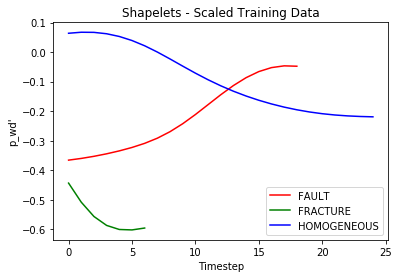

In [86]:
fig, ax = plt.subplots()
ax.set_xlabel("Timestep")
ax.set_ylabel("p_wd'")
ax.set_title("Shapelets - Scaled Training Data")
for k, v in shapelets_train_scaled.items():
    ax.plot(list(range(v.shape[0])), v, c=CLASS_COLORS[k])
ax.legend(handles=line_legend_elements)
plt.savefig(f"{FIG_FOLDER}/shapelets_synth_scaled.pdf", bbox_inches="tight")

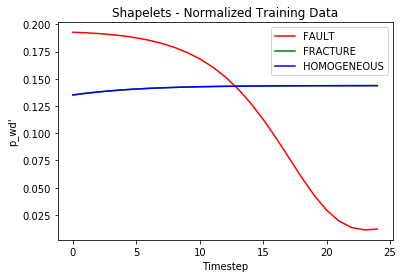

In [87]:
fig, ax = plt.subplots()
ax.set_xlabel("Timestep")
ax.set_ylabel("p_wd'")
ax.set_title("Shapelets - Normalized Training Data")
for k, v in shapelets_train_norm.items():
    ax.plot(list(range(v.shape[0])), v, c=CLASS_COLORS[k])
ax.legend(handles=line_legend_elements)
plt.savefig(f"{FIG_FOLDER}/shapelets_synth_norm.pdf", bbox_inches="tight")

In [88]:
from sklearn.metrics import multilabel_confusion_matrix

In [89]:
cm = {}
for k, v in yhat.items():
    cm[k] = multilabel_confusion_matrix(ytrue, v, labels=["HOMOGENEOUS", "FAULT", "FRACTURE"])

In [90]:
for k, v in cm.items():
    print(k)
    print(v)

scaled
[[[220  36]
  [ 48  80]]

 [[208  48]
  [ 11 117]]

 [[256   0]
  [ 25 103]]]
scaled_shapelet
[[[182  74]
  [114  14]]

 [[167  89]
  [ 45  83]]

 [[181  75]
  [ 79  49]]]
norm
[[[242  14]
  [  0 128]]

 [[256   0]
  [ 77  51]]

 [[180  76]
  [ 13 115]]]
norm_shapelet
[[[256   0]
  [  0 128]]

 [[256   0]
  [  0 128]]

 [[256   0]
  [  0 128]]]
